## Creating And Cleaning Features: Transform Skewed Features

### Read In Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from statsmodels.graphics.gofplots import qqplot

%matplotlib inline

In [2]:
titanic_df = pd.read_csv('../Data/titanic_capped.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_clean,Embarked_clean,Fare_clean
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,22.0,S,7.2500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38.0,C,71.2833
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0,S,7.9250
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0,S,53.1000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.0,S,8.0500


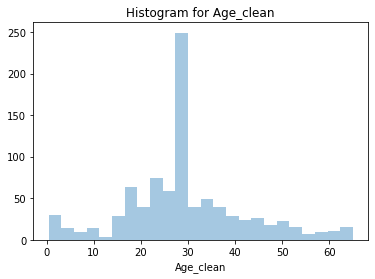

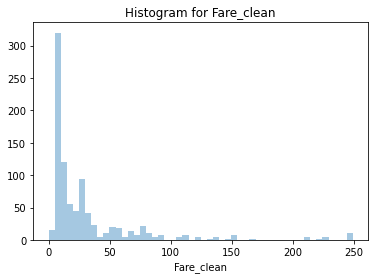

In [4]:
# Plot histogram for each continuous feature to see if a transformation is necessary or data is skewed
for feature in ['Age_clean', 'Fare_clean']:
    sns.distplot(titanic_df[feature], kde=False)
    plt.title('Histogram for {}'.format(feature))
    plt.show()

As we see from the above histograms,
- `Age_clean` is pretty decent normal distribution, except for the spike around 28-29.
- `Fare_clean` is right skewed distribution and tail is pretty long. Although capping data helps to lower the high end to 250, previously was 500 plus.  
so we will explore potential transformations to try to pull that tail in and make this more compact, well behaved distribution.

### Box-Cox Power Transformation

**Base Form** $$ y^x $$

| X    | Base Form           |           Transformation               |
|------|--------------------------|--------------------------|
| -2   | $$ y ^ {-2} $$           | $$ \frac{1}{y^2} $$      |
| -1   | $$ y ^ {-1} $$           | $$ \frac{1}{y} $$        |
| -0.5 | $$ y ^ {\frac{-1}{2}} $$ | $$ \frac{1}{\sqrt{y}} $$ |
| 0    | $$ y^{0} $$              | $$ log(y) $$             |
| 0.5  | $$ y ^ {\frac{1}{2}}  $$ | $$ \sqrt{y} $$           |
| 1    | $$ y^{1} $$              | $$ y $$                  |
| 2    | $$ y^{2} $$              | $$ y^2 $$                |

**Example (Using Fare)**

| Original value    | Transformation           |           Transformation               |
|------|--------------------------|--------------------------|
| $$ 50 $$    | $$ \frac{1}{50^2} $$           |  $$ 0.0004 $$      |
| $$ 50 $$    | $$ \frac{1}{50} $$          | $$ 0.02 $$        |
| $$ 50 $$  | $$ \frac{1}{\sqrt{50}} $$ | $$ 0.14 $$ |
| $$ 50 $$     | $$ log(50) $$              | $$ 1.7 $$             |
| $$ 50 $$   | $$ \sqrt{50} $$ | $$ 7.07 $$           |
| $$ 50 $$     | $$ 50 $$              | $$ 50 $$                  |
| $$ 50 $$     | $$ 50^2 $$           | $$ 2500 $$                |

**Process**

1. Determine what range of exponents to test
2. Apply each transformation to each value of your chosen feature
3. Use some criteria to determine which of the transformations yield the best distribution

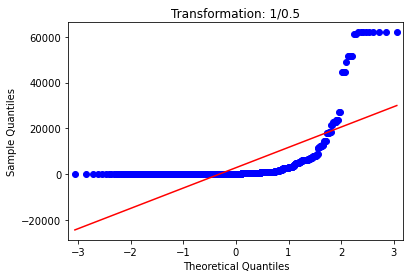

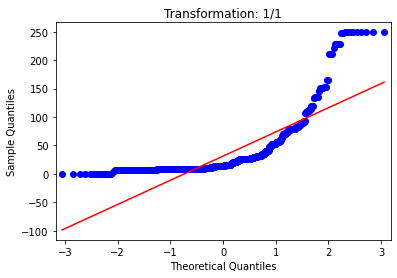

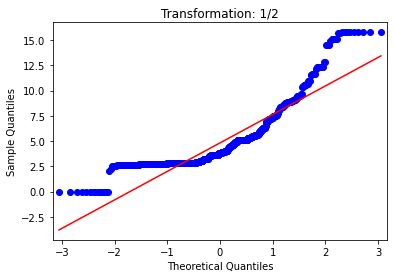

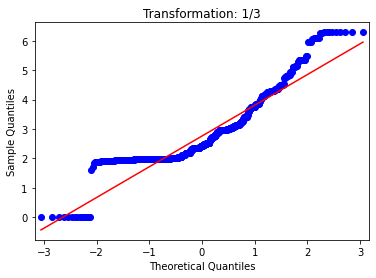

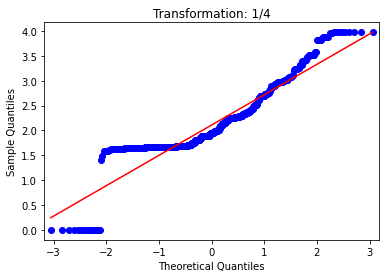

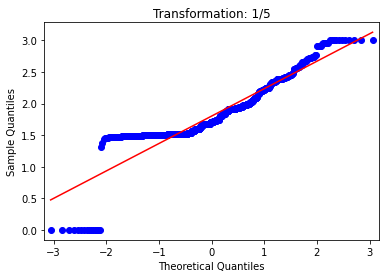

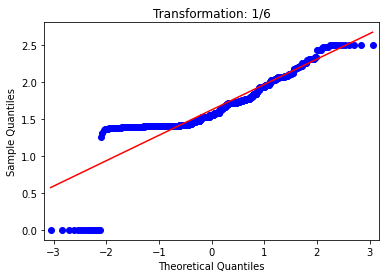

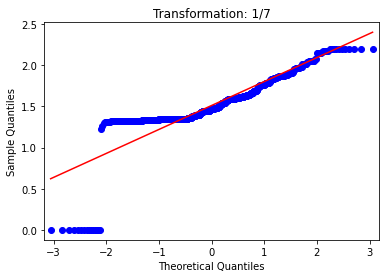

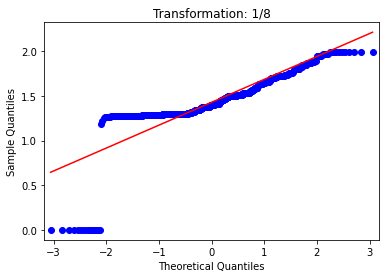

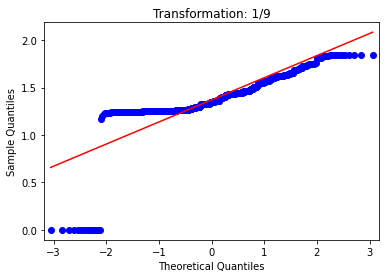

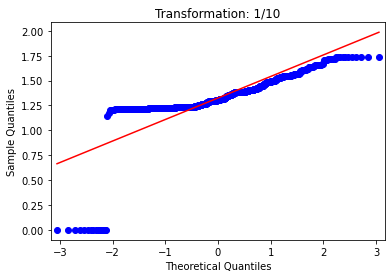

In [5]:
# Generate QQ plots
for i in [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    data_t = titanic_df['Fare_clean']**(1/i)
    qqplot(data_t, line='s')
    plt.title('Transformation: 1/{}'.format(str(i)))

- For QQPlot, we want to see `blue dots` line up with `red line`.
- we can see that points and line get better lined up better and better. So we will pick value start from 3, as before that line doesn't match that up so much.

--------

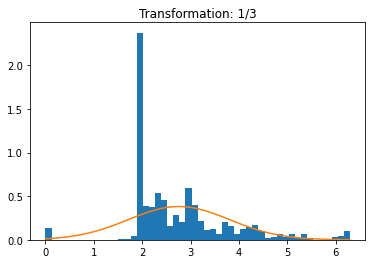

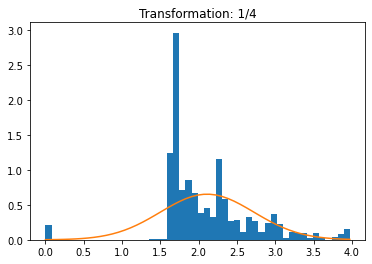

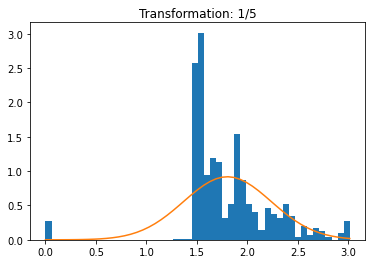

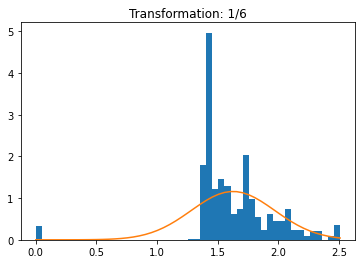

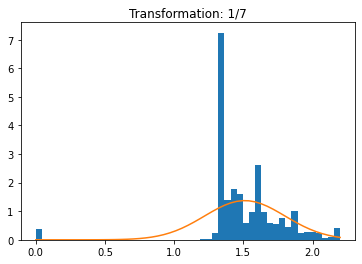

In [6]:
# Box-Cox transformation
# we want to see our data histogram compared to normal distribution looks like
for i in [3, 4, 5, 6, 7]:
    data_t = titanic_df['Fare_clean']**(1/i)
    n, bins, patches = plt.hist(data_t, 50, density=True)
    mu = np.mean(data_t)
    sigma = np.std(data_t)
    
    plt.plot(bins, scipy.stats.norm.pdf(bins, mu, sigma))
    plt.title('Transformation: 1/{}'.format(i))
    plt.show()

As we can see above none of them are perfect. But those are much better than our raw data. So it is reasonalbe to choose any of them.
We will choose 1/5.

---------

Now we have decided how to transform our data, we will proceed with transformation.

In [7]:
# Create the new transformed feature
titanic_df['Fare_clean_tr'] = titanic_df['Fare_clean'].apply(lambda x: x**(1/5))
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_clean,Embarked_clean,Fare_clean,Fare_clean_tr
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,22.0,S,7.2500,1.486167
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38.0,C,71.2833,2.347457
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0,S,7.9250,1.512864
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0,S,53.1000,2.213191
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.0,S,8.0500,1.517606


In [8]:
# Create new CSV with updated data
titanic_df.to_csv('../Data/titanic_transformed.csv', index=False)